In [146]:
# Import Packages
import warnings
import os
import gc
import numpy as np
import pandas as pd
import re
from datetime import datetime, timedelta
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates



# Suppress general warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)  # Ignore DeprecationWarnings
warnings.filterwarnings("ignore", category=UserWarning)  # Ignore UserWarnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # 0 = all logs, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR
np.seterr(all="ignore")

# pd.set_option("display.max_rows", None)  # Show all rows
# pd.set_option("display.max_columns", None)  # Show all columns (optional)
# pd.reset_option("display.max_rows")
# pd.reset_option("display.max_columns")

{'divide': 'ignore', 'over': 'ignore', 'under': 'ignore', 'invalid': 'ignore'}

In [ ]:
RESULTS_DIR = os.getcwd().replace("/_scripts", "/_results/Model/output")
output_csv = os.path.join(RESULTS_DIR,"merged_counts.csv")
# print(RESULTS_DIR)

In [ ]:
df = pd.read_csv(output_csv)
df.sort_values(by=["audiofile", "clip_no"], ascending=[True, True], inplace=True)
df.head()

In [ ]:
df = pd.read_csv(output_csv)
df.sort_values(by=["audiofile", "clip_no"], ascending=[True, True], inplace=True)
df.head()

In [ ]:
# Function to extract recorder number, date, and time
def extract_info(filename):
    pattern = r"([A-Za-z0-9]+)_(\d{8})_(\d{6})"
    match = re.search(pattern, filename)
    
    if match:
        recorder = match.group(1)   # Extract recorder number (e.g., S4A14476)
        date = match.group(2)        # Extract date (e.g., 20240208)
        time = match.group(3)        # Extract time (e.g., 163504)
        return recorder, date, time
    else:
        return None, None, None

In [ ]:
# Function to convert start_time to HH:MM:SS
def convert_seconds_to_time(seconds):
    return str(timedelta(seconds=int(seconds)))  # Convert start_time to HH:MM:SS

In [ ]:
def format_datetime(date_str, time_str, start_time):
    """ Adjusts time by adding start_time (in seconds) and handles midnight rollover """

    # ✅ Correct Date Format: Convert YYYYMMDD → YYYY-MM-DD
    formatted_date = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}"

    # ✅ Correct Time Format: Convert HHMMSS → HH:MM:SS
    formatted_time = f"{time_str[:2]}:{time_str[2:4]}:{time_str[4:]}"

    # ✅ Convert to datetime object
    base_time = datetime.strptime(f"{formatted_date} {formatted_time}", "%Y-%m-%d %H:%M:%S")

    # ✅ Add `start_time` in seconds
    adjusted_time = base_time + timedelta(seconds=start_time)

    # ✅ Extract new date and time
    new_date = adjusted_time.strftime("%Y-%m-%d")
    new_time = adjusted_time.strftime("%H:%M:%S")

    return new_date, new_time



In [ ]:
# Load your DataFrame (assuming `df` is your existing DataFrame)
df["recorder"], df["date"], df["time"] = zip(*df["audiofile"].apply(extract_info))
df["date"], df["time"] = zip(*df.apply(lambda row: format_datetime(row["date"], row["time"], row["start_time"]), axis=1))

In [ ]:
df.drop(columns=["start_time", "end_time", "filepath", "source_file"], inplace=True)
df = df[["audiofile","clip_no","recorder","date","time","prediction","confidence"]].copy()
df.sort_values(by=["date", "time"], inplace=True)
df.head()

In [ ]:
# display(df.head(3700).style.set_sticky())  # Enables scrolling while keeping headers fixed

In [ ]:
# ✅ Convert to datetime format
df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"])

In [129]:
# Read loudness data
df_loudness = os.path.join(RESULTS_DIR,"loudness_data.csv")
df_loudness = pd.read_csv(df_loudness)

# Ensure both DataFrames have matching columns for merging
df_loudness["clip_no"] = df_loudness["clip_no"].astype(int)
df["clip_no"] = df["clip_no"].astype(int)

# Merge the loudness data into the main DataFrame
df_merged = df.merge(df_loudness[["audiofile", "clip_no","energy"]], on=["audiofile", "clip_no"], how="left")
df_merged['sound'] = 20 * np.log10(np.maximum(df_merged.energy, 1e-10))
df_merged.head()

,audiofile,clip_no,recorder,date,time,prediction,confidence,datetime,energy,sound
0,S4A14476_20240208_163504.wav,1,S4A14476,2024-02-08,16:35:04,0,0.0,2024-02-08 16:35:04,0.065233,-23.710718
1,S4A14476_20240208_163504.wav,2,S4A14476,2024-02-08,16:35:05,0,0.0,2024-02-08 16:35:05,0.100767,-19.933591
2,S4A14476_20240208_163504.wav,3,S4A14476,2024-02-08,16:35:06,0,0.0,2024-02-08 16:35:06,0.116094,-18.703779
3,S4A14476_20240208_163504.wav,4,S4A14476,2024-02-08,16:35:07,0,0.0,2024-02-08 16:35:07,0.103081,-19.736412
4,S4A14476_20240208_163504.wav,5,S4A14476,2024-02-08,16:35:08,0,0.0,2024-02-08 16:35:08,0.094151,-20.523474


In [188]:
# ✅ Aggregate detections over time (choose a time interval)
df_time_series = df_merged.resample("3min", on="datetime")["prediction"].sum()  # 10-minute intervals

df_loudness_series = df_merged.resample("3min", on="datetime")["sound"].mean()

In [189]:
print(df.set_index("datetime").asfreq("3min").isnull().sum())


audiofile     144
clip_no       144
recorder      144
date          144
time          144
prediction    144
confidence    144
dtype: int64


In [174]:
# display(df_merged.head(5000).style.set_sticky())

In [184]:
df_time_series

2024-02-08 16:33:00    0.0
2024-02-08 16:36:00    0.0
2024-02-08 16:39:00    0.0
2024-02-08 16:42:00    0.0
2024-02-08 16:45:00    0.0
                      ... 
2024-02-10 16:48:00    0.0
2024-02-10 16:51:00    1.0
2024-02-10 16:54:00    0.0
2024-02-10 16:57:00    0.0
2024-02-10 17:00:00    0.0
Freq: 3min, Name: prediction, Length: 970, dtype: float64

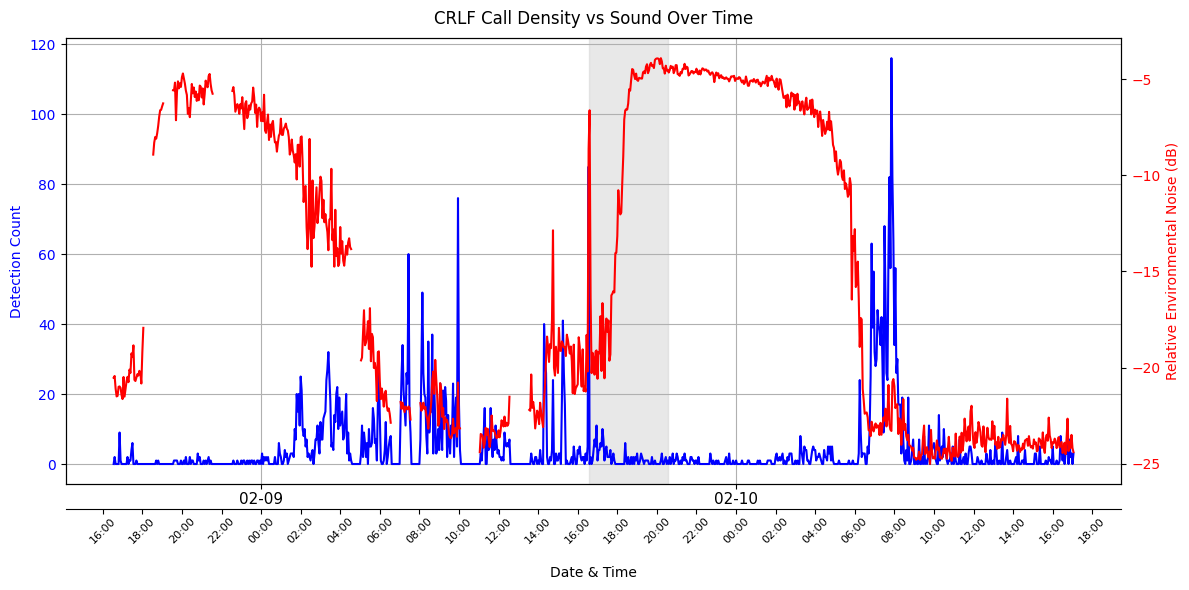

In [196]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ✅ Create Figure and Axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot detection count
ax1.plot(df_time_series.index, df_time_series.values, linestyle="-", label="Detection Count", color="blue")
# ax1.set_xlabel("Date", fontsize=12, labelpad=10)  # Add spacing for better readability
ax1.set_ylabel("Detection Count", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# ✅ Shade Launch Window (00:00 - 03:42 on 2/9)
launch_start = pd.Timestamp("2024-02-09 16:34:00")
launch_end = pd.Timestamp("2024-02-09 20:34:00")
ax1.axvspan(launch_start, launch_end, color="lightgray", alpha=0.5, label="Launch Window")

# Create a second y-axis for loudness
ax2 = ax1.twinx()
ax2.plot(df_loudness_series.index, df_loudness_series.values, linestyle="-", label="Sound", color="red")
ax2.set_ylabel("Relative Environmental Noise (dB)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# ✅ First Bottom X-Axis: Date Only
ax1.xaxis.set_major_locator(mdates.DayLocator())  # 📅 Show one tick per day
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))  # 🗓 Format as MM-DD
ax1.tick_params(axis="x", rotation=0, labelsize=11, pad=2)  # Ensure spacing

# ✅ Second Bottom X-Axis (Below Date) for Time
ax_time = ax1.secondary_xaxis('bottom')
ax_time.set_xlabel("Date & Time", fontsize=10, labelpad=15)  # Smaller label, add spacing
ax_time.xaxis.set_major_locator(mdates.HourLocator(interval=2))  # ⏰ Show every 2 hours
ax_time.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))  # Format as HH:MM
ax_time.tick_params(rotation=45, labelsize=8, pad=1)  # Rotate and add padding

# ✅ Stagger the Second X-Axis (Move it Down)
ax_time.spines["bottom"].set_position(("outward", 18))  # Push it downward for separation

# ✅ Adjust Title Position to Avoid Overlap
plt.title("CRLF Call Density vs Sound Over Time", pad=10)  # Move title up slightly

# ✅ Formatting
fig.tight_layout()  # 🚀 Automatically adjust layout to prevent overlap
ax1.grid(True)



fig_file = os.path.join(RESULTS_DIR,"call density vs sound.jpeg")
plt.savefig(fig_file, bbox_inches='tight')

# Show plot
plt.show()

In [192]:
# Read loudness data
merged_csv = os.path.join(RESULTS_DIR,"output_data.csv")
df_merged.to_csv(merged_csv)